# Loan Foreclosure Prediction

In this project, we are going to use the Fannie Mae Single-Family Loan Performance Data. This dataset contains millions of records about the lending and the follow-up of mortgage loans of the Federal National Mortgage Association (FNMA), commonly known as Fannie Mae. The data is made available every quarter since January 2000.

We will examining the data of mortgage loans and our goal will be to __predict whether a freshly acquired loan will be foreclosed before term-date.__ That is, by using the data available at acquisition time only, use Machine Learning techniques to predict the future foreclosure status.



### Summary of results

After analyzing, cleaning the data and running some machines learning models, it is found that gradient boosting machines offer the best results for predicting foreclosed loans at acquisition date. More specifically, the model yields a True positive rate of 50% and a False positive rate of 50%. This predictive models need to be coupled by a deep understanding of the loan companies business model in order to implement them properly and arrive at improvements.

To get a more detailed view at how these results are generated, please refer to the analysis below.

### Exploring the data

The loan data is made available by Fannie Mae at __[this address](http://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html)__, and is split into two different .txt file types:
 - The first, __Acquisition.txt__, describe the loans characteristics at the time they are signed. 
 - The second, __Performance.txt__, is a follow-up of the loans repayment on a monthly frequency. 

There is one Acquisition.txt and Performance.txt files per quarter, i.e. four per year

 
 
If we simply download and open one Acquisition file, here is what we get:

```100003665787|R|JPMORGAN CHASE BANK, NATIONAL ASSOCIATION|3.125|374000|360|08/2016|10/2016|80|80|1|32|805|N|P|PU|1|P|NE|681||FRM|||Y
100005168281|R|OTHER|2.875|330000|180|10/2016|12/2016|60|60|2|11|772|N|R|SF|1|S|PA|178||FRM|795||N
100005516991|R|OTHER|3.75|193000|360|09/2016|11/2016|90|90|1|36|680|N|R|PU|1|P|AZ|853|25|FRM||1|N
100005629219|R|OTHER|3.625|88000|360|12/2016|02/2017|74|74|2|43|737|N|C|SF|1|P|MI|490||FRM|755||N
100006141175|R|OTHER|2.75|371000|180|12/2016|02/2017|80|80|1|34|682|N|R|PU|1|P|TX|786||FRM|||N
100006975626|B|U.S. BANK N.A.|3.5|340000|360|09/2016|11/2016|66|66|1|19|793|N|R|CO|1|P|CA|914||FRM|||N
```

(Here are the first 6 rows of ```Acquisition_2016Q4.txt```)

As we can see, the data is organized in a CSV fashion with (```|```) as a delimiter. The data contains no headers, but the details of the layout of the Acquisition and Performance files can be found on the  __['File Layout' Page](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_File_layout.pdf)__
 
 Let's get a look at a sample of these files to get a more practical intuition:
 
 ## Acquisition data

In [1]:
import sys
sys.path.append("C:/Users/Maxime/PycharmProjects/")
sys.path.append("C:/Users/Maxime/PycharmProjects/FannieMae")
import pandas as pd
from FannieMae.settings import HEADER



file_path = 'C:\\Users\Maxime\\PycharmProjects\\FannieMae\\raw_data\\Acquisition_2016Q4.txt'
pd.read_csv(file_path, sep='|', names=HEADER['acquisition'], header=None, index_col=False, nrows=5)

,id,channel,seller,interest_rate,balance,loan_term,origination_date,first_payment_date,loan_to_value,combined_loan_to_value,...,property_type,unit_count,occupancy_status,property_state,zip,mortgage_insurance_percent,product_type,co_borrower_credit_score,mortgage_insurance_type,relocation_mortgage_indicator
0,100001420754,C,"PROVIDENT FUNDING ASSOCIATES, L.P.",3.375,217000,360,11/2016,01/2017,74,74,...,SF,1,P,PA,194,NaN,FRM,NaN,NaN,N
1,100003665787,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",3.125,374000,360,08/2016,10/2016,80,80,...,PU,1,P,NE,681,NaN,FRM,NaN,NaN,Y
2,100005168281,R,OTHER,2.875,330000,180,10/2016,12/2016,60,60,...,SF,1,S,PA,178,NaN,FRM,795.0,NaN,N
3,100005516991,R,OTHER,3.750,193000,360,09/2016,11/2016,90,90,...,PU,1,P,AZ,853,25.0,FRM,NaN,1.0,N
4,100005598239,R,"MOVEMENT MORTGAGE, LLC",3.875,414000,360,10/2016,12/2016,90,90,...,PU,1,P,NV,894,25.0,FRM,778.0,1.0,N


Each line in the __Acquisition__ data represents the acquisition of a new loan. Features includes origination date, Unpaid Principal Balance (UPB), loan seller name, or zip code of the property. These informations are going to be the features of our machine learning model.

## Performance data

In [2]:
file_path = 'C:\\Users\Maxime\\PycharmProjects\\FannieMae\\raw_data\\Performance_2016Q4.txt'
pd.read_csv(file_path, sep='|', names=HEADER['performance'], header=None, index_col=False, nrows=25)

,id,reporting_period,servicer_name,interest_rate,balance,loan_age,months_to_maturity,adjusted_months_to_maturitymaturity_date,msa,delinquency_status,...,tax_costs,sale_proceeds,credit_enhancement_proceeds,repurchase_proceeds,other_foreclosure_proceeds,non_interest_bearing_balance,principal_forgiveness_balance,principal_make_whole_proceeds_flag,foreclosure_principal_write_off_amount,servicing_activity_indicator
0,100001420754,12/01/2016,OTHER,3.375,NaN,0,360,360,12/2046,37980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100001420754,01/01/2017,NaN,3.375,NaN,1,359,359,12/2046,37980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100001420754,02/01/2017,NaN,3.375,NaN,2,358,358,12/2046,37980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100001420754,03/01/2017,NaN,3.375,NaN,3,357,357,12/2046,37980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100001420754,04/01/2017,"PROVIDENT FUNDING ASSOCIATES, L.P.",3.375,NaN,4,356,356,12/2046,37980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,100001420754,05/01/2017,NaN,3.375,NaN,5,355,355,12/2046,37980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,100001420754,06/01/2017,NaN,3.375,214891.00,6,354,354,12/2046,37980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,100001420754,07/01/2017,NaN,3.375,214536.03,7,353,353,12/2046,37980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,100001420754,08/01/2017,NaN,3.375,214180.06,8,352,352,12/2046,37980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,100001420754,09/01/2017,NaN,3.375,213823.09,9,351,351,12/2046,37980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Each line in the __Performance__ data corresponds to a monthly reporting of a given loan. Note that the id columns contains duplicates as each performance file contains the monthly reports of a loan for about one year. 

## Data pre-processing

For this project we are going to download the Acquisition.txt and Performance.txt records from all quarters of 2014, 2015 and 2016. Going for more even data might cause low-memory issues as the dataset become large.

The above data samples show the data in raw form.  In order to be able to use this data with machine learinng algortihms there is a data pre-processing task to perform. It can be divided into these five steps:
 - __Data files concatenation__: the files are split by quarter, and we need to merge the data to a single file
 - __Target column__: add a column that holds the information on whether or not the loan will be foreclosed after acquisition. (our surpervisory signal)
 - __Data cleaning__: we have to check if columns contains outsider or missing values and handle them
 - __Categorical features handling__: create dummy variables in order to include categorical features in the ML model
 - __Data re-sampling__: imbalanced classes data need to be rebalanced for the machine learning models to make good predictions

### Data files concatenation

The goal is to get two Dataframe objects to work with: one Acquisition and one Performance dataframe, containing all the records of the raw data stored in the many Acquisition.txt and Performance.txt files

#### Identifying the relevant data

Before jumping into this task, it is wise to define exactly what information we need from those .txt files in order to reduce the size of loaded data to a minimum. 

Our goal is to predict the foreclosure status of a loan based on all the informations gathered at acquisition time. Hence in order to get the best accuracy in our predictive models we need as many features as there are available. This means that all the columns of the Acquisition.txt files are going to be kept.

For our machine learning algorithms to be able to learn from training data and test their performance on test and validation data, we need to know whether a loan is foreclosed after acquisition, and this for every rows of the Acquisition.txt files. This foreclosure status is the __target variable__ of our machine learning model.

To create this target column, we need to know which loans are foreclosed. For this, we are going to use the Performance.txt files and look at the ```foreclosure_date``` column:

In [158]:
#Sample file for demonstration
file_path = 'C:\\Users\Maxime\\PycharmProjects\\FannieMae\\raw_data\\Performance_2014Q4.txt'
# Reading some ids from performance dataframe where there is a foreclosure
perf_sample = pd.read_csv(file_path, sep='|', names=HEADER['performance'], header=None, index_col=False, nrows=80000)
perf_sample.loc[perf_sample['id'].isin([101043819984, 101529401665]), ['id', 'reporting_period' , 'foreclosure_date']]

,id,reporting_period,foreclosure_date
17503,101043819984,12/01/2014,NaN
17504,101043819984,01/01/2015,NaN
17505,101043819984,02/01/2015,NaN
17506,101043819984,03/01/2015,NaN
17507,101043819984,04/01/2015,NaN
17508,101043819984,05/01/2015,NaN
17509,101043819984,06/01/2015,NaN
17510,101043819984,07/01/2015,NaN
17511,101043819984,08/01/2015,NaN
17512,101043819984,09/01/2015,NaN


Every row is the monthly report of a given loan. There is hence approximately twelve rows per loan ```id``` in every Performance.txt file.

As shown, the ```foreclosure_date``` column contains two types of values:
 - NaN if the loan has not been foreclosed and is still being repayed
 - The date of the foreclosure if the loan has been foreclosed
 
 
By keeping only the records where the ```foreclosure_date``` column is not NaN, we get all the loans that have been foreclosed.

Furthermore, if a loan is foreclosed, the record containing the foreclosure date will always be the last occurence in the sequence of duplicates ```id```. This means that we can drop all the duplicate ```id``` but the last one to detect which loans are foreclosed.
This analysis implies two things for our concatenation task:
 - From all the columns of the Performance dataframe, only the ```id``` and ```foreclosure_date``` columns are useful and the others can be dropped
 - From all the duplicate ```id``` rows, only the last occurences have to be looked at, and the other rows can be ignored
 
This is going to greatly reduce the amount of memory needed to handle the data.

#### Performing the concatenation

To perform the concatenation, we use the ```concatenate``` function that loads all the .txt data files and stores them into a concatenated .txt file with headers. The function also take care of selecting only the useful columns and looking only at the relevant rows from the Performance dataframe.


In [2]:
from FannieMae.data_processing import concatenate

# concatenate('acquisition', columns=HEADER['acquisition'])
# concatenate('performance', columns=['id', 'foreclosure_date'])

processed_path = 'C:\\Users\Maxime\\PycharmProjects\\FannieMae\\processed\\'
acqu = pd.read_csv(processed_path + 'acquisition_processed.txt', sep='|')
# perf = pd.read_csv(processed_path + 'performance_processed.txt', sep='|')

### Retrieving the foreclosure status of each loan

Now that the data is concatenated into ```acqu``` and ```perf```, we can perform operations on the whole data more easily.

As said above, our machine learning models need a target variable in order to train and test their accuracy. The target variable is going to be binary: 0 if the loan is not be foreclosed on the future, 1 if it is. This is then a classification problem. We are going to append a column called ```foreclosure_status``` to ```acqu``` containing this target value for every row.

We begin by storing the foreclosed loans ```id``` from ```perf``` into a new dataframe called ```foreclosed``` 

In [15]:
# Keeping only the Non-NaN values
foreclosed = perf.loc[perf['foreclosure_date'].notnull(), ['id']]

# Saving the data for safety
from FannieMae.settings import PROCESSED_DATA_PATH
foreclosed.to_csv(PROCESSED_DATA_PATH + 'foreclosed_id.txt', sep="|", index=False)

Now, some ```id``` of ```foreclosed``` might not be found in ```acqu```, as it is possible that the corresponding foreclosed loan have been acquired at a time that go before the range of data we have in our dataset (from 2014 to 2016).

From the ```id``` present in ```foreclosed```, we want to check which are also present in ```acqu``` and set the corresponding ```foreclosure_status``` value to 1. The ```foreclosure_status``` values from rows that have not been set to 1 are set to 0.
This is done by performing a join operation between ```foreclosed``` and ```acqu``` on the ```id``` column.

In [3]:
foreclosed = pd.read_csv(processed_path + 'foreclosed_id.txt', sep='|')

# All the rows in foreclosed have 'foreclosed_status' equal to 1
foreclosed['foreclosed_status'] = 1

# Join operation
target = pd.merge(acqu.loc[:, 'id'].to_frame(), foreclosed, on='id', how='outer')

# All the NaN values are non-foreclosed loans, hence fill NaN with 0's
target.fillna(0, inplace=True)

The target dataframe now contains all the loan ```id``` of ```acqu```, with a 1 in the ```foreclosure_status``` column if it is foreclosed and a 0 if it is not. The final step is to append the ```foreclosure_status``` to the Acquisition dataframe



In [4]:
acqu = pd.concat([acqu, target['foreclosed_status']], axis=1)

### Data cleaning

For the machine learning algorithms to run properly, data must be exempt of missing values. Let's take a look at the occurences of missing values in our data:

In [18]:
acqu.isna().sum()

id                                     0
channel                                0
seller                                 0
interest_rate                          0
balance                                0
loan_term                              0
origination_date                       0
first_payment_date                     0
loan_to_value                          0
combined_loan_to_value                 1
borrower_count                         0
debt_to_income_ratio                1050
borrower_credit_score               2116
first_time_homebuyer                   0
loan_purpose                           0
property_type                          0
unit_count                             0
occupancy_status                       0
property_state                         0
zip                                    0
mortgage_insurance_percent       3763061
product_type                           0
co_borrower_credit_score         2572450
mortgage_insurance_type          3763061
relocation_mortg

We see that  ```debt_to_income_ratio```,   ```borrower_credit_score``` and ```combined_loan_to_value``` columns contain some NaN values. The proportion of NaNs in these columns compared to the number of rows in the data is pretty low (< 0.05%) so it is possible to delete the rows containing these NaN values without losing too much information.

In [5]:
acqu = acqu.dropna(subset=['borrower_credit_score', 'debt_to_income_ratio', 'combined_loan_to_value'])

For the ```mortgage_insurance_percent```, ```co_borrower_credit_score``` and ```mortgage_insurance_type``` columns,  the proportion of NaNs is non-negligible and we need to take a closer look.

In [22]:
acqu.loc[:, ['borrower_count', 'mortgage_insurance_percent', 'co_borrower_credit_score', 'mortgage_insurance_type']]

,borrower_count,mortgage_insurance_percent,co_borrower_credit_score,mortgage_insurance_type
0,1,NaN,NaN,NaN
1,1,NaN,NaN,NaN
2,1,NaN,NaN,NaN
3,1,NaN,NaN,NaN
4,2,NaN,812.0,NaN
5,1,NaN,NaN,NaN
6,2,NaN,729.0,NaN
7,2,NaN,816.0,NaN
8,2,NaN,778.0,NaN
9,2,30.0,742.0,1.0


#### mortgage_insurance_type column

Let's study the contents of ```mortgage_insurance_type``` column

In [24]:
acqu['mortgage_insurance_type'].unique()

array([nan,  1.,  2.])

It turns out that the ```mortgage_insurance_type``` only contains 3 distinct values: 1, 2 and NaN. A NaN value here simply indicates that the borrower doesn't have any mortgage insurance. We can take the whole information of this column by setting the NaN values to 0, indicating an absence of mortgage insurance, and creating dummy variables later on.

In [6]:
acqu['mortgage_insurance_type'].fillna(0, inplace=True)

#### co_borrower_credit_score column

The NaN values in this column are found in the rows where the ```number_borrowers``` column is equal to 1. This makes sense, as there can't be a score for the co-borrower if the loan is taken by a person alone. One solution to take this column into account would be to split the data into two groups, one with a ```co_borrower_credit_score``` column and another without, and apply our model on both groups. However this could lead to a loss of accuracy in greatly imbalanced classes data like this one.

A quick correlation study shows us that it is fine to drop this column because most of the information it contains is already present in the ```credit_score``` column.

In [229]:
acqu['borrower_credit_score'].corr(acqu['co_borrower_credit_score'])

0.6840726668228869

The correlation coefficient is about 0.68. Having highly correlated features like these could harm the predictive power of our models, so it is recommended to drop the ```co_borrower_credit_score``` column

In [7]:
acqu.drop(columns='co_borrower_credit_score', inplace=True)

#### mortgage_insurence_percent column

There is no pattern to predict which borrowers did or did not take an insurance for the mortgage. Setting NaN values to 0 could decrease accuracy as the machine learning model infer these values exist on a continuum: having no mortgage insurance is different than having a mortgage insurance of 0%! In order not to give wrong information to our models, let's drop this column as well.

In [8]:
acqu = acqu.drop(columns=['mortgage_insurance_percent'])

### Dummy variables

Our data contains numerous categorical features, i.e. features that can take on one of a limited number of possible values. 
For our machine learning model to handle this values, we must create dummy variables out of these features.

Before that, let's handle the ```date``` and ```first_payment_date``` columns. In order to create dummy variables out of these columns, we first need to split them into ```month``` and ```year```. It is then possible to get dummy variables out of these new columns and keep the information.

In [14]:
    # Splitting date column into month and year column
    acqu['month'] = acqu['origination_date'].str[:2]
    acqu['year'] = acqu['origination_date'].str[3:]
    acqu = acqu.drop(columns=['origination_date'])
    # Same for first_payment_date column
    acqu['fp_month'] = acqu['first_payment_date'].str[:2]
    acqu['fp_year'] = acqu['first_payment_date'].str[3:]
    acqu = acqu.drop(columns=['first_payment_date'])

It is now possible to get dummy variables out of all the categorical features.

In [15]:
# Categorical columns
cat_col = ['channel', 'seller', 'first_time_homebuyer', 'loan_purpose', 'property_type',
               'occupancy_status', 'property_state', 'product_type', 'relocation_mortgage_indicator', 'month', 'year',
               'fp_month', 'fp_year', 'mortgage_insurance_type', 'zip']

acqu = pd.get_dummies(acqu, prefix=cat_col, columns=cat_col)

### Last details

We conclude this data pre-processing part by dropping the ```combined_loan_to_value``` column as there is a high correlation between this column and ```loan_to_value```

In [32]:
acqu['loan_to_value'].corr(acqu['combined_loan_to_value'])


0.9811758154511487

In [9]:
acqu = acqu.drop(columns=['combined_loan_to_value'])

We also drop the ```id``` column as it has no predictive power.

In [10]:
acqu = acqu.drop(columns=['id'])

 ### Data re-sampling
 
 One important thing to note here is that our dataset is extremely imbalanced:

In [9]:
number_foreclosed = len(acqu[acqu['foreclosed_status']==1])
number_loans = len(acqu)
print('Negatives to positives ratio: ' + str(int((number_loans - number_foreclosed)/number_foreclosed)) + ':1')

Negatives to positives ratio: 2488:1


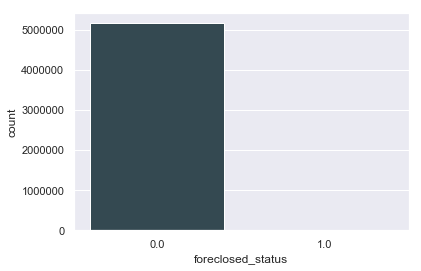

In [6]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set_palette("PuBuGn_d")
sns.countplot(data=acqu, x='foreclosed_status')

Having such imbalanced classes can damage the prediction power of our algorithms because there will not be a big proportion of information about positive examples in comparison with negative examples. The abundant information about negative examples will slow our computations and bias our results.

For this reason we are going to rebalance the classes be randomly dropping some negative examples, so that we reach a proportion of foreclosed loans of about 10%.

In [12]:
# Shuffling acqu rows
acqu = acqu.sample(frac=1).reset_index(drop=True)

In [13]:
# Computing the number of negative examples to drop
percentage = 0.1
neg_number_to_keep = int(number_foreclosed / percentage)
neg_number_to_drop = number_loans - neg_number_to_keep

# Removing the negative examples
mask1 = acqu['foreclosed_status'] == 0
mask2 = acqu.index < neg_number_to_drop
mask = mask1 & mask2
acqu = acqu.drop(acqu[mask].index)

In [25]:
number_foreclosed = len(acqu[acqu['foreclosed_status']==1])
number_loans = len(acqu)
print('New proportion of foreclosed loans: ' + str('%.3f' % (number_foreclosed/number_loans*100)) + '%')

New proportion of foreclosed loans: 9.093%


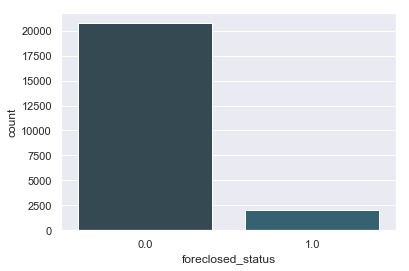

In [20]:
sns.countplot(data=acqu, x='foreclosed_status')

## Applying a machine learning model


### Picking appropriate metrics

Since our problem involves imbalanced classes, we must choose metrics that are not affected by the proportion of the classes. Both accuracy and F1 scores can take different values for a given model if the ratio of negative versus positive examples changes. 

We are going to use True positive rate and False positive rate, as those metrics reflect the prediction power of our model regardless of the composition of the classes.

There is a trade-off between TPR and FPR as the threshold varies. Thus, in order to get a single number metric, we are going to look at the ROC AUC score, which takes both TPR and FPR into account. 

To give more intuitve results of the predictive power of the algorithms, confusion matrix, TPR and FPR will also be computed. The issue is that those metrics need a certain value of the threshold to be provided. To solve this, for the first algorithm, we are going to compute confusion matrix, TPR and FPR using the threshold that maximizes the F1 score. For the next two algorithms, we will simply modify the threshold by hand to get equal values of TPR, so that the metrics can be compared.

All our model are going to use 10-fold cross-validation. It has been concluded after several tries that nor features scaling or PCA did improve the results, which is the reason why we are not going to implement these algorithms.

Let's split our data between features matrix X and target vector y

In [16]:
X = acqu.drop(columns=['foreclosed_status'])
y = acqu['foreclosed_status']

The data is now ready to be used by some machine learning algorithms. We are going to use four different algorithms and compare their performance:
 - Logistic regression
 - Random forests
 - Gradient boosting classifier
 
 
 These three algorithms can be used as classifiers, i.e. predict a feature that can take a limited number of different values (here 0 or 1)

### Logistic regression



In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

clf = LogisticRegression(class_weight='balanced', C=100)
y_pred = cross_val_predict(clf,  X, y, cv=10, n_jobs=-1, method='predict_proba')

For this time, we are going to pick the threshold that maximizes the F1 score. For the next algorithms, we will simply modify the threshold manually so that FPR values are equal to the logistic regression's FPR for comparison

best F1 score: 0.48120300751879697 obtained with threshold = 0.73644201544421
With this threshold, precision = 0.40115718418514945, recall = 0.6011560693641619


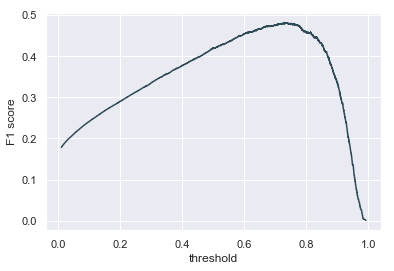

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the F1 curve and returns the optimal threshold value and index
# Compute precision and recall in order to get F1 score
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y, y_pred[:, 1])
f1 = 2 * (precision * recall) / (precision + recall)
f1 = f1[:-1]

optimal_threshold = thresholds[np.argmax(f1)]
optimal_threshold_index = np.argmax(f1)

# F1 score curve
fig = plt.figure()
plt.xlabel('threshold')
plt.ylabel('F1 score')
sns.lineplot(x=thresholds, y=f1)

print('best F1 score: ' + str(max(f1)) + ' obtained with threshold = ' + str(optimal_threshold))
print('With this threshold, precision = ' + str(precision[optimal_threshold_index]) + ', recall = ' + str(recall[optimal_threshold_index]))

In [313]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix, FPR and TPR
y_p = (y_pred[:,1] > thresholds[np.argmax(f1)]).astype(np.int)
c = confusion_matrix(y, y_p)
print(c)
print()
print('FPR: ' + str(c[0][1]/(c[0][1]+c[0][0])))
print('TPR: ' + str(c[1][1]/(c[1][1]+c[1][0])))
print()

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y, y_pred[:, 1]))

[[18925  1823]
 [  837  1239]]

FPR: 0.08786389049546944
TPR: 0.596820809248555

0.8870794194987988


What matters here are the two final values of FPR and TPR. 
These values mean:
 - Among the non-foreclosed loans, we predicted 8.7% of them to be foreclosed (and succeded predicting 91.3% of the others)
 - Among the foreclosed loans, we predicted 60% of them to be foreclosed (and failed predicting 40% of the others)
 
 
The ROC AUC score is 0.887. This is the main criterion we use to compare algorithm predictive power for this project.
 
Let's now implement other algorithms in the same fashion and compare the results.

### Random Forest

In [220]:
from sklearn.ensemble import RandomForestClassifier
max_features = 50
max_depth = 45
min_samples_leaf = 5
nb_estimators = 50
clf = RandomForestClassifier(n_estimators=nb_estimators, n_jobs=-1, class_weight='balanced', max_features=max_features, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

In [221]:
y_pred = cross_val_predict(clf,  X, y, cv=10, n_jobs=-1, method='predict_proba')

In [303]:
# Compute confusion matrix, FPR and TPR0.5577
threshold = 0.9
y_p = (y_pred[:,1] > threshold).astype(np.int)
c = confusion_matrix(y, y_p)
print(c)
print()
print('FPR: ' + str(c[0][1]/(c[0][1]+c[0][0])))
print('TPR: ' + str(c[1][1]/(c[1][1]+c[1][0])))
print()
print(roc_auc_score(y, y_pred[:, 1]))

[[20740     8]
 [ 2027    49]]

FPR: 0.000385579332947754
TPR: 0.023603082851637765

0.8963738362506235


Here we get results that are slightly better that those of logistic regression, that is for a constant FPR value, random forests yields TPR = 0.648

The ROC AUC score is 0.888, which means the random forest has almost the same predictive power as logistic regression

### Gradient boosting classifier

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
max_features = 22
max_depth = 22
min_samples_leaf = 5
nb_estimators = 200
learning_rate = .1
subsample =1
clf = GradientBoostingClassifier(subsample=subsample, learning_rate=learning_rate, n_estimators=nb_estimators, max_features=max_features, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

In [23]:
y_pred = cross_val_predict(clf,  X, y, cv=10, n_jobs=-1, method='predict_proba')

In [26]:
# Compute confusion matrix, FPR and TPR using the optimal threshold0.1527
threshold = 0.1527
y_p = (y_pred[:,1] > threshold).astype(np.int)
c = confusion_matrix(y, y_p)
print(c)
print()
print('FPR: ' + str(c[0][1]/(c[0][1]+c[0][0])))
print('TPR: ' + str(c[1][1]/(c[1][1]+c[1][0])))
print()
print(roc_auc_score(y, y_pred[:, 1]))

[[18556  2191]
 [  702  1374]]

FPR: 0.10560562972959946
TPR: 0.661849710982659

0.8953997156122487


The gradient boosting machines do an even better job at predicting the values, with a ROC AUC of 0.897.

With this setup:
 - Among the non-foreclosed loans, we predicted 10% of them to be foreclosed (and succeded predicting 90% of the others)
 - Among the foreclosed loans, we predicted 67% of them to be foreclosed (and failed predicting 33% of the others)

In the context of a practical use of these predictive models, we might expect that Fannie Mae's goal is to maximize the precision of the signal, as they want to avoid discarding safe loans. 

Putting that as a priority amounts to increasing the threshold. In doing so, the recall decreases, and it is up to the business team to determine the precision and recall levels that are the most suitable. 

Text(0.5,1,'precision and recall as a function of threshold')

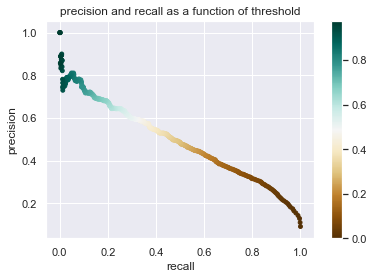

In [43]:
precision = []
recall =[]
thresholds = []
# Getting the precision, recall and threshold values for 500 points between 0 and 1
for i in range(0, 500): 
    threshold = i/500
    y_p = (y_pred[:,1] > threshold).astype(np.int)
    c = confusion_matrix(y, y_p)
    if (c[0][1] + c[1][1]) != 0 and (c[1][0] + c[1][1]) != 0: # cannot divide by 0
        thresholds.append(threshold)
        precision.append(c[1][1] / (c[0][1] + c[1][1]))
        recall.append(c[1][1] / (c[1][0] + c[1][1]))

points = plt.scatter(recall, precision,
                     c=thresholds, s=15, cmap="BrBG")
plt.colorbar(points)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision and recall as a function of threshold')

With a threshold of 0.3, any foreclosure prediction has 50% chance of being true, while we catch 50% of the foreclosed loans.

Increasing the threshold to 0.75, foreclosure predictions have a 70% of proving to be true, while we catch 11% of foreclosed loans.

## Conclusion

In this project, we analyzed, processed and run machine learning models on raw mortgage loans data in order to predict which loans are foreclosed, using the information available at acquisition time only.

The best algorithm for prediction is gradient boosting machines, which can yield a True positive rate of 50% and a False positive rate of 50%.

While the predictive model has not astonishing accuracy, it can provide some help to mortgage loan companies like Fannie Mae according to their business structures. Improvements to the models could be made by adding new features to the data, or increasing the number of positive examples by getting additional data. 